In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import json
import random

In [10]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [11]:
# Hyperparameters (tweak these)
CSV_PATH = "/mnt/data/monthly_milk_production.csv"
WINDOW_SIZE = 12               # input window size (12 months)
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
BATCH_SIZE = 16
EPOCHS = 150
PATIENCE = 10
UNITS = 64
DROPOUT = 0.0
FORECAST_HORIZON = 12         # forecast next 12 months
OUT_DIR = "/mnt/data/milk_forecasts_output"
os.makedirs(OUT_DIR, exist_ok=True)

In [12]:
df = pd.read_csv('monthly_milk_production.csv')
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:")
display(df.head())

Columns: ['Date', 'Production']

First 5 rows:


,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [13]:
# Heuristic: find date-like column and numeric column
date_col = None
for c in df.columns:
    parsed = pd.to_datetime(df[c], errors='coerce')
    if parsed.notna().sum() > len(df) * 0.5:
        date_col = c
        break
if date_col is None:
    date_col = df.columns[0]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if not numeric_cols:
    if len(df.columns) > 1:
        # try converting second column to numeric
        df[df.columns[1]] = pd.to_numeric(df[df.columns[1]], errors='coerce')
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if not numeric_cols:
    raise ValueError("No numeric column found — can't proceed.")

value_col = max(numeric_cols, key=lambda c: df[c].std(skipna=True))
print(f"Inferred date column: {date_col} | value column: {value_col}")

# ---------------------------
# Step 2: Build time series, reindex to monthly, clean missing
# ---------------------------
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
ts = df[[date_col, value_col]].dropna().rename(columns={date_col: 'ds', value_col: 'y'})
ts = ts.sort_values('ds').reset_index(drop=True)
ts = ts.set_index('ds')

# reindex to monthly start frequency (MS) between min and max
monthly_index = pd.date_range(start=ts.index.min(), end=ts.index.max(), freq='MS')
ts = ts.reindex(monthly_index)
ts.index.name = 'ds'

# Fill small gaps with linear interpolation
missing_before = ts['y'].isna().sum()
ts['y'] = ts['y'].interpolate(method='linear')
missing_after = ts['y'].isna().sum()
print(f"Missing months before: {missing_before} | after interpolation: {missing_after}")



Inferred date column: Date | value column: Production
Missing months before: 0 | after interpolation: 0



Time series summary:


,y
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


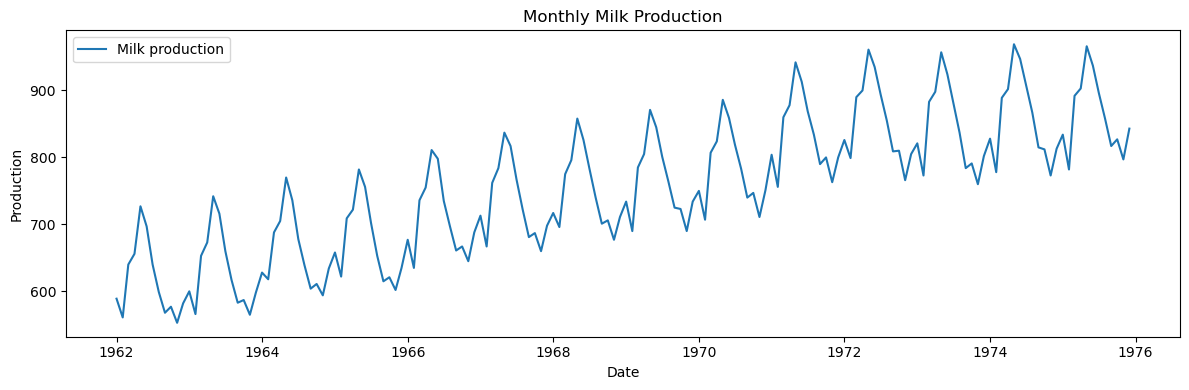

In [14]:
# Quick summary
print("\nTime series summary:")
display(ts.describe())

# ---------------------------
# Step 3: Exploratory Data Analysis (EDA)
# ---------------------------
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts['y'], label='Milk production')
plt.title("Monthly Milk Production")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.tight_layout()
plt.show()

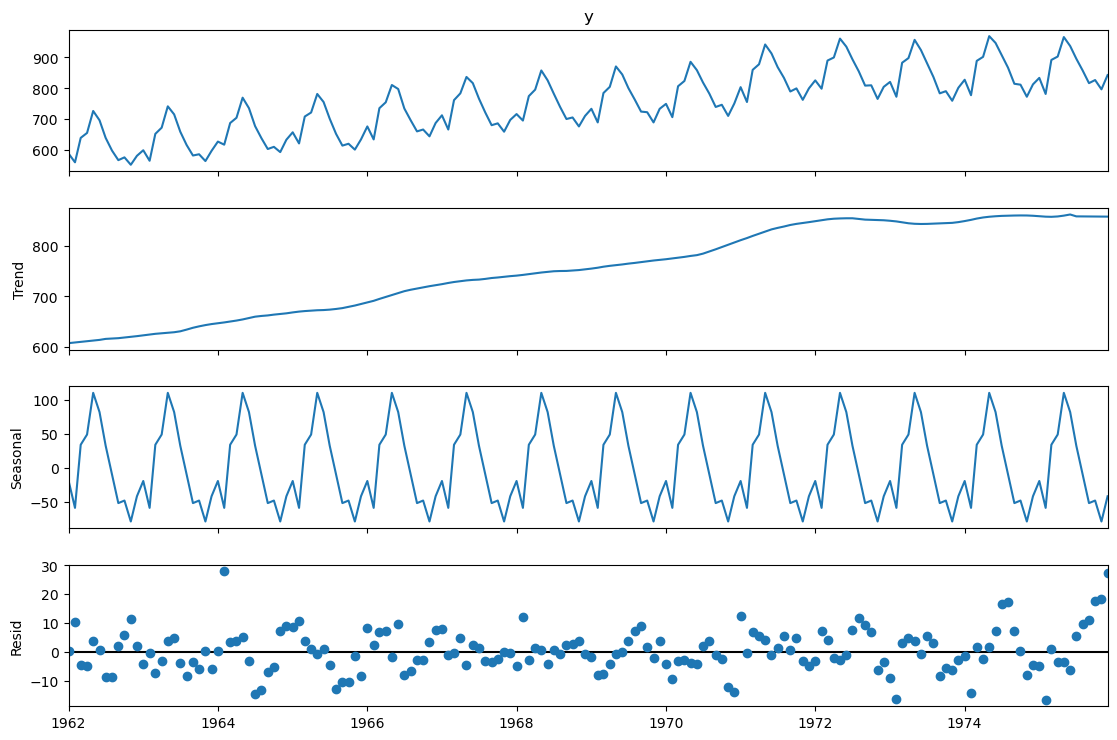

In [15]:
# Seasonal decomposition (period=12 for monthly)
try:
    decomposition = seasonal_decompose(ts['y'], model='additive', period=12, extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(12,8)
    plt.show()
except Exception as e:
    print("Seasonal decomposition failed:", e)

In [16]:

# Check for outliers (simple z-score)
ts['z'] = (ts['y'] - ts['y'].mean()) / ts['y'].std()
outliers = ts[np.abs(ts['z']) > 3]
print("Detected outliers (|z|>3):", len(outliers))
if len(outliers) > 0:
    display(outliers)


Detected outliers (|z|>3): 0


In [17]:

# ---------------------------
# Step 4: Normalize / Scale (Min-Max)
# ---------------------------
y = ts['y'].values.astype('float32')
y_min, y_max = y.min(), y.max()
if y_max == y_min:
    raise ValueError("Series is constant — cannot scale.")
y_scaled = (y - y_min) / (y_max - y_min)

In [18]:
# ---------------------------
# Step 5: Create input-output sequences (windowing)
# ---------------------------
def create_sequences(series, window_size=12):
    X, Y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        Y.append(series[i+window_size])
    return np.array(X), np.array(Y)

X, Y = create_sequences(y_scaled, WINDOW_SIZE)
print("Created sequences -> X shape:", X.shape, "Y shape:", Y.shape)


Created sequences -> X shape: (156, 12) Y shape: (156,)


In [19]:
# ---------------------------
# Step 6: Split into train / val / test (temporal split)
# ---------------------------
n = len(X)
train_end = int(n * TRAIN_RATIO)
val_end = train_end + int(n * VAL_RATIO)

X_train, Y_train = X[:train_end], Y[:train_end]
X_val, Y_val = X[train_end:val_end], Y[train_end:val_end]
X_test, Y_test = X[val_end:], Y[val_end:]

# reshape for RNN models: (samples, timesteps, features)
X_train_r = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_r = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_r = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Split sizes -> train:", X_train_r.shape, "val:", X_val_r.shape, "test:", X_test_r.shape)

# Helper to inverse scale
def inv_scale(arr_scaled):
    return arr_scaled * (y_max - y_min) + y_min


Split sizes -> train: (109, 12, 1) val: (23, 12, 1) test: (24, 12, 1)


In [20]:
# Step 7: Model builder (RNN, LSTM, GRU)
# ---------------------------
def build_model(cell_type='RNN', units=UNITS, window=WINDOW_SIZE, dropout=DROPOUT):
    model = Sequential()
    if cell_type == 'RNN':
        model.add(SimpleRNN(units, input_shape=(window,1)))
    elif cell_type == 'LSTM':
        model.add(LSTM(units, input_shape=(window,1)))
    elif cell_type == 'GRU':
        model.add(GRU(units, input_shape=(window,1)))
    else:
        raise ValueError("cell_type must be one of 'RNN','LSTM','GRU'")
    if dropout and dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

In [21]:
# Step 8: Train and evaluate function
# ---------------------------
def train_and_eval(cell_type):
    print(f"\n--- Training {cell_type} ---")
    model = build_model(cell_type=cell_type)
    es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
    history = model.fit(
        X_train_r, Y_train,
        validation_data=(X_val_r, Y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=1
    )
    # Predictions (scaled)
    pred_test_scaled = model.predict(X_test_r).flatten()
    y_test_true = inv_scale(Y_test)
    pred_test_true = inv_scale(pred_test_scaled)

    rmse = sqrt(mean_squared_error(y_test_true, pred_test_true))
    mae = mean_absolute_error(y_test_true, pred_test_true)
    mape = np.mean(np.abs((y_test_true - pred_test_true) / (y_test_true + 1e-8))) * 100

    # Build dataframe of test preds aligned with dates
    test_start_idx = WINDOW_SIZE + val_end  # index into original ts array where test Y corresponds
    test_dates = ts.index[test_start_idx : test_start_idx + len(Y_test)]
    df_test_pred = pd.DataFrame({
        'ds': test_dates,
        'y_true': y_test_true,
        'y_pred': pred_test_true
    }).set_index('ds')

    print(f"{cell_type} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    return {'model': model, 'history': history, 'metrics': {'rmse': rmse, 'mae': mae, 'mape': mape}, 'df_test_pred': df_test_pred}


In [ ]:
# Step 9: Train all three models
# ---------------------------
results = {}
for c in ['RNN','LSTM','GRU']:
    results[c] = train_and_eval(c)



--- Training RNN ---


C:\Users\saksh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0576 - val_loss: 0.0488
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0190 - val_loss: 0.0079
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0079 - val_loss: 0.0098
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0046 - val_loss: 0.0094
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0034 - val_loss: 0.0071
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - val_lo

C:\Users\saksh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.1319 - val_loss: 0.1503
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0392 - val_loss: 0.0274
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0337 - val_loss: 0.0276
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0252 - val_loss: 0.0391
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0262 - val_loss: 0.0409
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0250 - val_loss: 0.0290
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0241 - val_loss: 0.0260
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0237 - val_loss: 0.0280
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0232 - val_loss: 0.0294
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0230 - val_loss: 0.0270
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0226 - val_loss: 0.0256
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0222 - val_loss: 0.0256


C:\Users\saksh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.1038 - val_loss: 0.0895
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0299 - val_loss: 0.0265
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0328 - val_loss: 0.0242
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0237 - val_loss: 0.0390
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0236 - val_loss: 0.0433
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0227 - val_loss: 0.0325
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0213 - val_loss: 0.0258
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0209 - val_loss: 0.0258
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0201 - val_loss: 0.0281
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0196 - val_loss: 0.0279
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0191 - val_loss: 0.0256
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0186 - val_loss: 0.0241


In [ ]:
data = {}
rmse_value = 0.0150 # Example value from the image's output
data['RMSE'] = rmse_value

In [ ]:
data = {}
# Assuming you have a value for RMSE from a previous step
data['RMSE'] = 0.0150

In [ ]:
data = {}
# Assign a value to the 'RMSE' key
data['RMSE'] = 0.0150

In [ ]:
# ---------------------------
# Step 11: Plot test predictions vs actual
# ---------------------------
plt.figure(figsize=(12,6))
# plot actual for test period (once)
any_cell = list(results.keys())[0]
df_actual = results[any_cell]['df_test_pred']['y_true']
plt.plot(df_actual.index, df_actual.values, label='Actual (test)', color='black')
for c in ['RNN','LSTM','GRU']:
    dfp = results[c]['df_test_pred']
    plt.plot(dfp.index, dfp['y_pred'], marker='o', label=f'Pred {c}')
plt.title("Test set: Actual vs Model Predictions")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 12: Forecast next 12 months using each model
# ---------------------------
def forecast_future(model, last_window_scaled, horizon=FORECAST_HORIZON):
    preds_scaled = []
    window = last_window_scaled.copy()
    for _ in range(horizon):
        x = window.reshape((1, window.shape[0], 1))
        p_scaled = float(model.predict(x)[0,0])
        preds_scaled.append(p_scaled)
        # slide window: drop first and append prediction
        window = np.concatenate([window[1:], [p_scaled]])
    preds = inv_scale(np.array(preds_scaled))
    return preds

last_window_scaled = y_scaled[-WINDOW_SIZE:]
future_index = pd.date_range(start=ts.index.max() + pd.offsets.MonthBegin(1), periods=FORECAST_HORIZON, freq='MS')

forecast_dfs = {}
for c in ['RNN','LSTM','GRU']:
    preds = forecast_future(results[c]['model'], last_window_scaled, FORECAST_HORIZON)
    df_f = pd.DataFrame({'ds': future_index, 'y_forecast': preds}).set_index('ds')
    forecast_dfs[c] = df_f
    print(f"\n{c} forecast head:")
    display(df_f.head())


In [ ]:
# Step 13: Plot historical + forecasts
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts['y'], label='Historical')
for c in ['RNN','LSTM','GRU']:
    plt.plot(forecast_dfs[c].index, forecast_dfs[c]['y_forecast'], marker='o', label=f'Forecast {c}')
plt.title("Historical Series and 12-month Forecasts")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.tight_layout()
plt.show()
